Required libraries

In [ ]:
!pip3 install pmdarima

##Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import regex as re
import math
from datetime import datetime
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from itertools import cycle
import matplotlib.pyplot as plt

##Importing and preparing the Dataset

In [2]:
dataset = pd.read_csv('Load Profiles.csv')
dataset

,Date/Time,Heating/Cooling,Fans,InteriorLights,ExteriorLights,InteriorEquipment,Misc : InteriorEquipment
0,01/01 01:00:00,0.249108,0.048803,0.061268,0.011206,2.826843,0.315209
1,01/01 02:00:00,0.286937,0.056214,0.035740,0.006537,3.130111,0.290224
2,01/01 03:00:00,0.313726,0.061462,0.025528,0.004669,3.371758,0.286859
3,01/01 04:00:00,0.336854,0.065993,0.025528,0.004669,3.607986,0.282821
4,01/01 05:00:00,0.358424,0.070219,0.025528,0.004669,3.888659,0.272138
...,...,...,...,...,...,...,...
8755,12/31 20:00:00,0.098779,0.019352,0.295776,0.054100,2.069969,0.501625
8756,12/31 21:00:00,0.105840,0.020735,0.269368,0.049269,2.015142,0.518871
8757,12/31 22:00:00,0.112770,0.022093,0.227114,0.041541,1.967728,0.506757
8758,12/31 23:00:00,0.129033,0.025279,0.169015,0.030914,1.971973,0.438533


In [3]:
Total = []
for row in dataset.to_numpy():
    Total.append(np.sum(row[1:]))

In [4]:
x = []
for el in dataset['Date/Time']:
    match = re.match(r'^ ([0-9]{2})\/([0-9]{2})  ([0-9]{2})', el)
    x.append(datetime(2020, int(match[1]), int(match[2]), hour=int(match[3])-1))

In [5]:
data = pd.DataFrame()
data['DateTime'] = pd.Series(x)
data['Load'] = pd.Series(Total)
data

,DateTime,Load
0,2020-01-01 00:00:00,3.512436
1,2020-01-01 01:00:00,3.805763
2,2020-01-01 02:00:00,4.064003
3,2020-01-01 03:00:00,4.323852
4,2020-01-01 04:00:00,4.619638
...,...,...
8755,2020-12-31 19:00:00,3.039602
8756,2020-12-31 20:00:00,2.979224
8757,2020-12-31 21:00:00,2.878003
8758,2020-12-31 22:00:00,2.764748


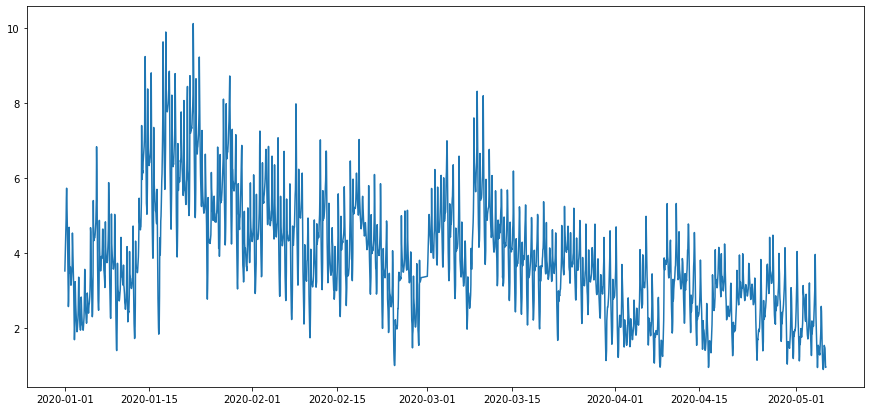

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(data.DateTime[:3000], data.Load[:3000])
plt.grid(False)
plt.show()

In [7]:
def plot_moving_average(series, window, plot_intervals = False, scale = 1.06):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

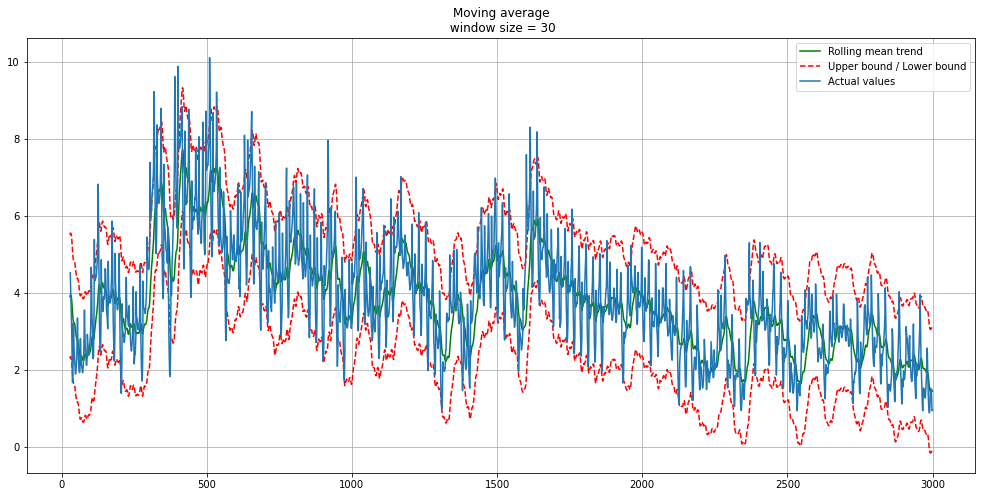

In [8]:
plot_moving_average(data.Load[:3000], 30, plot_intervals=True)

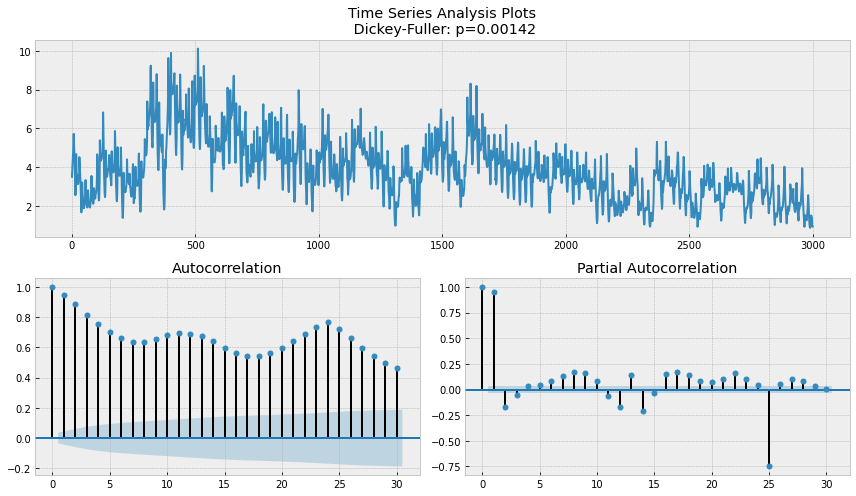

In [9]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
def tsplot(data, lags=None):
        
    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize=(12,7))
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        data.plot(ax = ts_ax)
        p_value = sm.tsa.stattools.adfuller(data)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Load[:3000], lags=30)

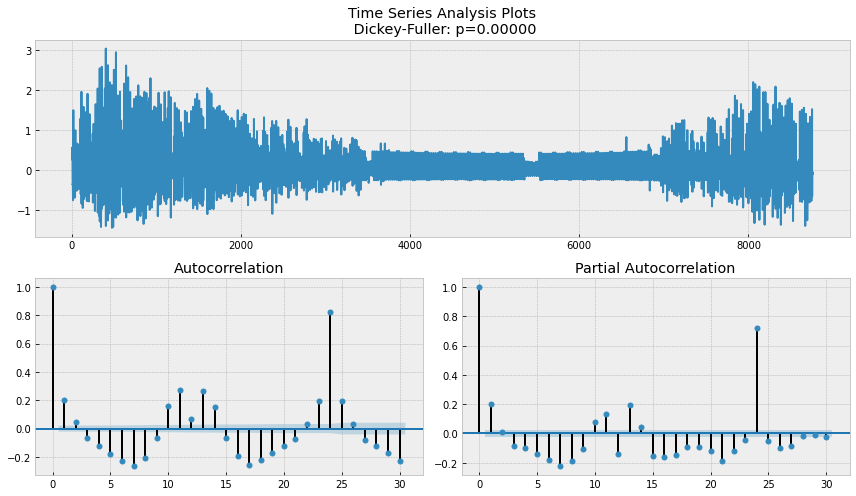

In [10]:
data_diff = data.Load - data.Load.shift(1)

tsplot(data_diff[1:], lags=30)

In [11]:
train = data.Load[:6570]
test = data.Load[6570:]

In [12]:
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(train, order=(3,0,4))
model_fit_arima = model_arima.fit()
print(model_fit_arima.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Conv

                              ARMA Model Results                              
Dep. Variable:                   Load   No. Observations:                 6570
Model:                     ARMA(3, 4)   Log Likelihood               -1189.527
Method:                       css-mle   S.D. of innovations              0.290
Date:                Sun, 18 Apr 2021   AIC                           2397.054
Time:                        11:33:31   BIC                           2458.166
Sample:                             0   HQIC                          2418.179
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3416      0.305      7.678      0.000       1.744       2.939
ar.L1.Load     2.7222      0.000   5652.796      0.000       2.721       2.723
ar.L2.Load    -2.7149      0.001  -3532.927      0.0

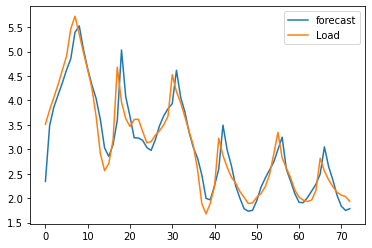

In [13]:
fig = model_fit_arima.plot_predict(0, 72)

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(train, seasonal_order=(3,0,4,4))
model_fit_sarimax = model_sarimax.fit(disp=0)
print(model_fit_sarimax.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                          SARIMAX Results                                           
Dep. Variable:                                         Load   No. Observations:                 6570
Model:             SARIMAX(1, 0, 0)x(3, 0, [1, 2, 3, 4], 4)   Log Likelihood                -651.752
Date:                                      Sun, 18 Apr 2021   AIC                           1321.503
Time:                                              11:34:27   BIC                           1382.616
Sample:                                                   0   HQIC                          1342.629
                                                     - 6570                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9926      0.001  

Forecasting Load for the next 48 hours

In [15]:
pred = model_fit_sarimax.get_prediction(
    start=data.shape[0],
    end=data.shape[0]+48,  # predict next 48 values 
    dynamic=False,
)

In [16]:
predictions = pred.predicted_mean

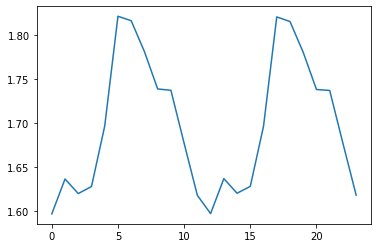

In [17]:
plt.plot(np.array(predictions)[:24])
plt.show()